#Training a Neural Network in PyTorch#

PyTorch is a powerful, widely-used machine learning library. It has all the latest neural network layers and functions and supports GPU computation.

Most neural network research these days either happens in PyTorch or TensorFlow. Google Research develops TensorFlow while Facebook AI Research develops PyTorch. Functionally they are probably very similar, I just know a lot of people who use PyTorch and it seems like it might be somewhat easier for beginners to learn. It is important to have some experience in one of these two frameworks but if you understand the ideas and concepts you shouldn't have too much trouble moving between them.

The `torch` library provides the basic functions we need when dealing with `tensors`. `tensors` are a generalization of matrices to arbirtrary numbers of dimensions (a matrix is a 2D tensor). Types of tensors:


*   0 dimensional: Scalar
*   1 dimensional: Array
*   2 dimensional: Matrix
*   3 dimensional: Number cubey thingy
*   4 dimensional: ?????

Anywho, let's start with our opening chant to invoke the power of PyTorch to aid us. The last line is a special call to the GPU gods to smile on our endeavor.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Time For Some Data##

PyTorch has some built tools for downloading and loading common datasets. We'll be playing around with MNIST in this example. It is a dataset of 28x28 grayscale handwritten digits 0-9. There are 50,000 images in the training set and 10,000 in the test set.



In [2]:
def get_mnist_data():
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=8)

  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                      transform=transforms.ToTensor())
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                          num_workers=8)
  classes = range(10)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_mnist_data()

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


###Understanding Our Data ###
It's worthwhile to check out how our dataloader loads the images into tensors. We can print out the size of the loaded data in the `images` tensors.



In [3]:
# get some random training images
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(images.size())



torch.Size([32, 1, 28, 28])


Our `images` tensor is 4-dimensional, (32 x 1 x 28 x 28)

PyTorch stores image data in (N x C x H x W) format. Thus the size of this tensor implies we have a mini-batch of 32 images, each have a single channel (grayscale), and each image is 28 x 28, so that makes sense!

We can use matplotlib to see what our data looks like:

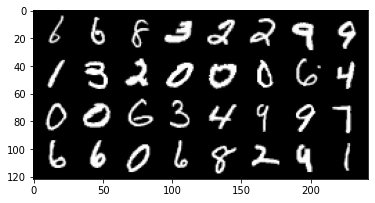



        6         6         8         3


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % data['classes'][labels[j]] for j in range(4)))


##A Simple Network##

First we'll build a very basic neural network with a single hidden layer of neurons. This means one fully connected layer of weights connects the input to the hidden neurons and one fully connected layer connects the hidden neurons to the output. We'll use the RELU activation function on the hidden neuron values as our nonlinearity.

These fully connected (or `nn.Linear`) layers expect a 2D input tensor where that is N x I where N is the number of data points in a mini batch and I is the number of inputs. However, our data is formatted in (N x C x H x W) right now so we need to tell PyTorch to rearrange it using `torch.flatten`.

After being `flatten`ed our data goes from (32 x 1 x 28 x 28) to being (32 x 784)

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self, inputs=28*28, hidden=512, outputs=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

###The Training Function ###

Now for training our network. Our `train` function takes as input the `net` to train and the `dataloader` for the training data. It also takes some optional parameters to control training.

For our network we'll be using PyTorch's built in `nn.CrossEntropyLoss`. This will apply a softmax to our network's output, calculate the log-probability assigned to each class, then try to minimize the negative log likelihood of our data (AKA maximize the likelihood)

For our optimizer we are using stochastic gradient descent with learning rate, momentum, and decay parameters.

In [6]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.1, momentum=0.7, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

###Training The Network###

We'll instantiate a new network and train it on our training data.

Our training function prints out some debug information about the epoch, batch number, and current loss values. It also returns a list of all the losses on our mini-batches so we can plot them all once training has finished.

[1,   100] loss: 0.793
[1,   200] loss: 0.383
[1,   300] loss: 0.302
[1,   400] loss: 0.260
[1,   500] loss: 0.254
[1,   600] loss: 0.216
[1,   700] loss: 0.220
[1,   800] loss: 0.179
[1,   900] loss: 0.180
[1,  1000] loss: 0.155
[1,  1100] loss: 0.163
[1,  1200] loss: 0.136
[1,  1300] loss: 0.150
[1,  1400] loss: 0.144
[1,  1500] loss: 0.142
[1,  1600] loss: 0.127
[1,  1700] loss: 0.131
[1,  1800] loss: 0.134


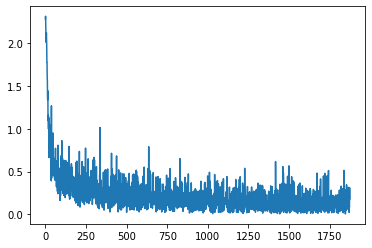

In [7]:
net = SimpleNet()

losses = train(net, data['train'])
plt.plot(losses)

##Testing The Network##

We trained our network! The loss went down! That's good, right? But how good is our network, exactly?

Well, we can try running our network on a few of our test images and see what happens:

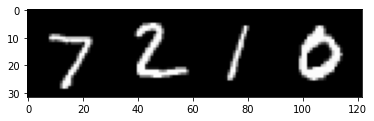

GroundTruth:      7     2     1     0
Predicted:      7     2     1     0


In [8]:
dataiter = iter(data['test'])
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data['classes'][labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % data['classes'][predicted[j]]
                              for j in range(4)))

Pretty good so far. But we also want to be able to test the network on all of our data. Here's a function that can do just that, computing the accuracy on a full set of data:

In [9]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

Now we can give it a try:

In [10]:
print("Current accuracy: %f" % accuracy(net, data['train']))

Current accuracy: 0.970067


##Experiments##

Now it's time to poke around a little bit with our models. First I just want this utility function to do window smoothing of data for us. As you may have noticed, we are doing *stochastic* gradient descent, so our losses for each mini-batch can vary quite dramatically. If we smooth them out a little bit they will be easier to look at when we plot them.

In [11]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='same')

###Learning Rate###

Let's experiment around with the learning rate of our model. Changing the learning rate should affect how fast our model converges and how accurate it is. We can see the effect when we plot out the loss function over time for models with different learning rates:

0.9648 0.9219 0.8466


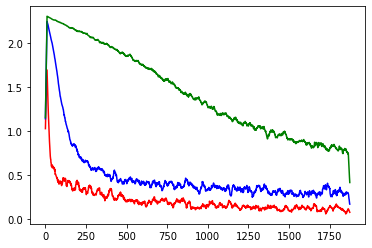

In [12]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###Momentum###

We are using the default value for momentum of `0.9`. Fix your value for the learning rate and try varying the values for momentum.

####**Question 1: What affect does changing the value for momentum have on your model's convergence and final accuracy?**####

After applying various different momentum and learning rate, I found some very interesting behaviors. Such as, I found that as the learning rate increase, the model that have higher learning rate will be more likely to be closer to convergence more than the lower learning rate when compare with the at the exact time. For a very low learning rate like 0.001, the model convergence has always droped sharply at the very end. 

For the effect of momentum, I found that it may help reduce the the training time, even though it was not particularly noticable. I have expermented with different momentum value as shown in below plots. I have noticed that, after the momentum is greater than 1, it seems the convergence will become less likely to converge to zero as the momentum goes beyond 0.9. The updated weight is also become unlikely to be able to find the local minima. From the defult values of learning rate 0.1 and momentum 0.9, the best accuracy that I've got is 96.9% from having momentum of 0.7 and keeping the learning rate constant of 0.1.

0.963 0.9127 0.8031


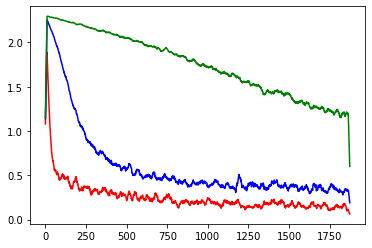

In [13]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=0.5, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, momentum=0.5, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, momentum=0.5, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

0.954 0.9017 0.7609


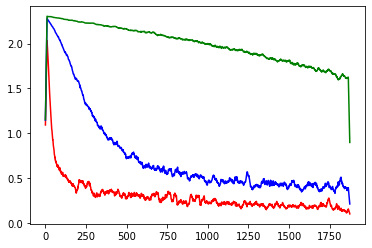

In [14]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=0.2, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, momentum=0.2, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, momentum=0.2, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

0.098 0.098 0.098


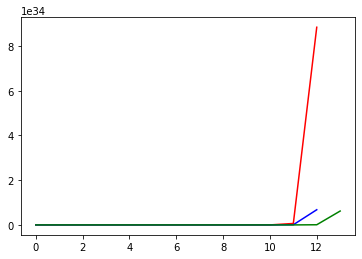

In [15]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=10, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, momentum=10, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, momentum=10, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

0.098 0.098 0.098


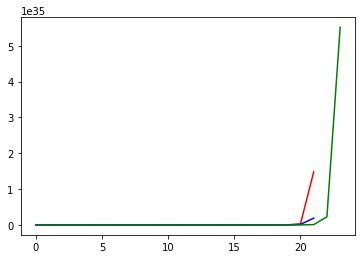

In [16]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=5, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, momentum=5, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, momentum=5, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

0.1099 0.479 0.9132


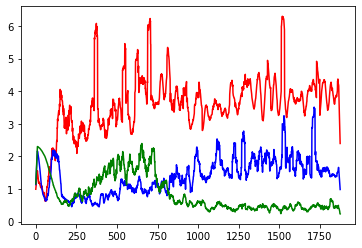

In [17]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, momentum=1, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, momentum=1, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

0.9572 0.9461 0.895


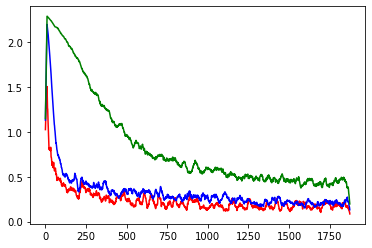

In [18]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=0.9, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, momentum=0.9, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, momentum=0.9, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###Weight Decay###

Right now we aren't using any weight decay with our model. However, it can be useful as a method of regularization if we are worried about overfitting.

Take your best performing model parameters from above for learning rate and momentum. Fix these parameters as you answer the following questions:

####**Question 2: Is our current model overfit or underfit to our training data? How can you tell?**####

My current model is neither underfit nor overfit as the current accuracy for training data is 97.4%, while the current accuracy for testing data: is 96.9%. This is also because if they model is appear to be overfitting, we should see much larger different between training vs testing data accuratecy, where acc_traingg >> acc_trainging. And we can expect to have a very low accuracy for both testing and training if it was underfit. 

####**Question 3: Try out some different values for weight decay. What effect do they have on model convergence? What about final accuracy? Does this match with what you would have expected? Why or why not?**####

As the weight decay goes up, I found that the accuracy drop accordingly. At the same time, the model becomes more unlikely to converge to zero as well. There is the a threshold that lies between the weight decay of 0.2-0.5 where it makes the model gone way off. This goes as I expected since the weight decay counteracs to the weight of the model, if the weight decay is too large or closer to 1, the output will be mot much different than the input or likely to be the same as the input.

Current accuracy for training data: 0.966333
Current accuracy for testing data: 0.962300


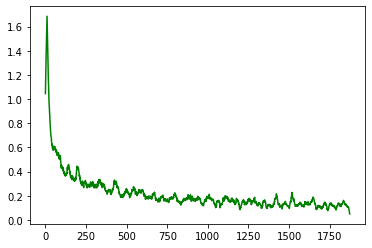

In [19]:
# accuracy to see whether current model overfit or underfit 

net = SimpleNet()
losses = train(net, data['train'], lr=.1, momentum=0.7, verbose=0)
acc_train = accuracy(net, data['train'])
acc_test = accuracy(net, data['test'])
plt.plot(smooth(losses,20), 'g-')

print("Current accuracy for training data: %f" % acc_train)
print("Current accuracy for testing data: %f" % acc_test)

0.8847 0.8493 0.7683 0.7056 0.1436 0.098 0.101


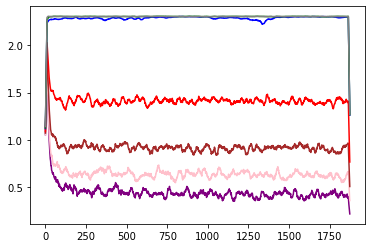

In [20]:
net_1 = SimpleNet()
losses_1 = train(net_1, data['train'], lr=.1, momentum=0.7, decay=0.02, verbose=0)
acc_1 = accuracy(net_1, data['test'])
plt.plot(smooth(losses_1,20), 'purple')

net_2 = SimpleNet()
losses_2 = train(net_2, data['train'], lr=.1, momentum=0.7, decay=0.05, verbose=0)
acc_2 = accuracy(net_2, data['test'])
plt.plot(smooth(losses_2,20), 'pink')


net_3 = SimpleNet()
losses_3 = train(net_3, data['train'], lr=.1, momentum=0.7, decay=0.1, verbose=0)
acc_3 = accuracy(net_3, data['test'])
plt.plot(smooth(losses_3,20), 'brown')

net_4 = SimpleNet()
losses_4 = train(net_4, data['train'], lr=.1, momentum=0.7, decay=0.2, verbose=0)
acc_4 = accuracy(net_4, data['test'])
plt.plot(smooth(losses_4,20), 'r-')


net_5 = SimpleNet()
losses_5 = train(net_5, data['train'], lr=.1, momentum=0.7, decay=0.5, verbose=0)
acc_5 = accuracy(net_5, data['test'])
plt.plot(smooth(losses_5,20), 'b-')


net_6 = SimpleNet()
losses_6 = train(net_6, data['train'], lr=.1, momentum=0.7, decay=0.7, verbose=0)
acc_6 = accuracy(net_6, data['test'])
plt.plot(smooth(losses_6,20), 'g-')

net_7 = SimpleNet()
losses_7 = train(net_7, data['train'], lr=.1, momentum=0.7, decay=1, verbose=0)
acc_7 = accuracy(net_7, data['test'])
plt.plot(smooth(losses_7,20), 'grey')


print(acc_1, acc_2, acc_3, acc_4, acc_5, acc_6, acc_7)

###A Bigger Model###

Before we used a very simple model but now it's time to try adding some complexity. Create a network that takes as input the 28x28 image, 10 outputs, and any number of layers as long as it has fewer than 2,000,000 connections. Our simple network before had 784\*512 + 512\*10 = 406,528 connections.

Use only fully connected (`nn.Linear`) layers (we'll get to other layer types soon). However, play around with different [activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions), [losses](https://pytorch.org/docs/stable/nn.html#loss-functions), and hyperparameter settings. You can also try different training regimes. For example, you could try lowering the learning rate during training by calling our training method twice like this:

    train(net, data['train'], epochs=5, lr=.1)
    train(net, data['train'], epochs=3, lr=.01)
    train(net, data['train'], epochs=2, lr=.001)

Maybe it works better? Why did I choose those particular numbers? Who knows! It's deep learning, no one really knows what will work you have to just try things and see.

Experiment with different network architectures and settings to get the most accurate model.

####**Question 4: Describe your final model architecture. How did you come up with the number of layers and number of neurons at each layer?**####

My final model includes 3 different layers that goes through Relu and leaky relu activaiton function accordingly. I was trying to mimic the model that I have previously designed in the coding in C part of the assignment that it reachted about 97% with the similar structures. The reason that I have to relu is to zero out the negative negative feathers and try to collect more information by passing leaky relu activation function to collect more information as x = 0.1x for x < 0. 


####**Question 5: What hyperparameters did you experiment with? What values were good for them? Do you think your model was over or under fitting the data?**####

I experimented with the different values of hyperparameters but I decided to stick with the ones that produce best performance on my previous model. And based on the accuracy, I used the same rational form the above that my model is neither overfit or underfit as we should see much larger different between training vs testing data accuratecy, where acc_traingg >> acc_trainging, if it was overfit. Or we can expect to have a very low accuracy for both testing and training if it was underfit. 

In [27]:
#TODO: Write your new model and experiments here

class ExperiNet(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x



# class ExperiNet2(nn.Module):
#     #TODO: Change all this
#     def __init__(self):
#         super(ExperiNet2, self).__init__()
#         self.fc1 = nn.Linear(28*28, 512)
#         self.fc2 = nn.Linear(512, 512)
#         self.fc3 = nn.Linear(512, 250)
#         self.fc4 = nn.Linear(250, 10)

#     def forward(self, x):
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = F.leaky_relu(x)
#         x = self.fc3(x)
#         x = F.leaky_relu(x)
#         x = self.fc4(x)
#         return x

# class ExperiNet3(nn.Module):
#     #TODO: Change all this
#     def __init__(self):
#         super(ExperiNet3, self).__init__()
#         self.fc1 = nn.Linear(28*28, 512)
#         self.fc2 = nn.Linear(512, 512)
#         self.fc3 = nn.Linear(512, 250)
#         self.fc4 = nn.Linear(250, 10)

#     def forward(self, x):
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.leaky_relu(x)
#         x = self.fc2(x)
#         x = F.hardswish(x)
#         x = self.fc3(x)
#         x = F.hardswish(x)
#         x = self.fc4(x)
#         return x

Current accuracy: 0.973183
Current accuracy: 0.965600
Current accuracy: 0.971017
Current accuracy: 0.967200
Current accuracy: 0.965617
Current accuracy: 0.961200


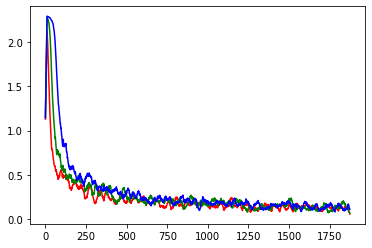

In [29]:
net_exp = ExperiNet()
losses_1 = train(net_exp, data['train'], lr=.1, momentum=0.7, decay=0, verbose=0)
print("Current accuracy exp #1 train: %f" % accuracy(net_exp, data['train']))
print("Current accuracy exp #1 test: %f" % accuracy(net_exp, data['test']))
plt.plot(smooth(losses_1,20), 'r-')

# net_exp2 = ExperiNet2()
# losses_2 = train(net_exp2, data['train'], lr=.1, momentum=0.7, decay=0, verbose=0)
# print("Current accuracy exp #2 train: %f" % accuracy(net_exp2, data['train']))
# print("Current accuracy exp #2 test: %f" % accuracy(net_exp2, data['test']))
# plt.plot(smooth(losses_2,20), 'g-')

# net_exp3 = ExperiNet3()
# losses_3 = train(net_exp3, data['train'], lr=.1, momentum=0.7, decay=0, verbose=0)
# print("Current accuracy exp #3 train: %f" % accuracy(net_exp3, data['train']))
# print("Current accuracy exp #3 test: %f" % accuracy(net_exp3, data['test']))
# plt.plot(smooth(losses_3,20), 'b-')

##Download and submit!##

Download your iPythorn notebook from Colab to your `hw0` directory. Then follow the instructions to collate and submit your homework.